In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Cognitive scores from ADNIMERGE
df_cog = pd.read_csv('/content/drive/Shareddrives/ECS289L/ADNIMERGE_11May2025.csv')

# Diagnostic codes over time
df_dx = pd.read_csv('/content/drive/Shareddrives/ECS289L/DXSUM_11May2025.csv')


<ipython-input-34-fc844db211fe>:4: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cog = pd.read_csv('/content/drive/Shareddrives/ECS289L/ADNIMERGE_11May2025.csv')


##Identify MCI-at-Baseline Patients from DX File

In [ ]:
# Filter only MCI-at-baseline patients
df_bl = df_dx[df_dx['VISCODE2'] == 'bl']  # baseline visits only
df_bl_mci = df_bl[df_bl['DIAGNOSIS'] == 2.0]  # 2.0 = MCI
mci_rids = df_bl_mci['RID'].unique()
print("MCI baseline patients:", len(mci_rids))


MCI baseline patients: 1214


##Create Labels (pMCI vs sMCI)

In [ ]:
# Filter all records of those MCI baseline patients
df_mci_all = df_dx[df_dx['RID'].isin(mci_rids)].copy()

# Label: 1 if diagnosis ever becomes AD (3.0), else 0
labels = {}
for rid, group in df_mci_all.groupby('RID'):
    diagnoses = group['DIAGNOSIS'].dropna().unique().tolist()
    labels[rid] = 1 if 3.0 in diagnoses else 0

# Show label distribution
from collections import Counter
label_counts = Counter(labels.values())
print("Label distribution:", label_counts)

Label distribution: Counter({0: 816, 1: 398})


##Filter and Clean All 7 Features

In [ ]:
# Select the columns we need from ADNIMERGE
cols = ['RID', 'VISCODE', 'MMSE', 'CDRSB', 'ADAS13', 'RAVLT_immediate',
        'RAVLT_learning', 'RAVLT_forgetting', 'FAQ']
df_cog = df_cog[cols]

# ✅ Filter patients that have labels
df_cog = df_cog[df_cog['RID'].isin(labels)]

# ✅ Drop rows with missing values in any of the 7 features
features = ['MMSE', 'CDRSB', 'ADAS13', 'RAVLT_immediate',
            'RAVLT_learning', 'RAVLT_forgetting', 'FAQ']
df_cog = df_cog.dropna(subset=features)

# ✅ Sort by RID and visit time
df_cog = df_cog.sort_values(by=['RID', 'VISCODE'])

# ✅ Build sequences
patient_sequences = {}
for rid, group in df_cog.groupby('RID'):
    seq = group[features].values.tolist()
    patient_sequences[rid] = seq


##Align with Label Dictionary

In [ ]:
df_cog = df_cog[df_cog['RID'].isin(labels)]

##Build Sequences (with 7 features now)

In [ ]:
patient_sequences = {}
for rid, group in df_cog.groupby('RID'):
    seq = group[['MMSE', 'CDRSB', 'ADAS13', 'RAVLT_immediate',
                 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ']].values.tolist()
    patient_sequences[rid] = seq

##Pad and Convert to Arrays

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

SEQ_LEN = 12

X = []
y = []

for rid, seq in patient_sequences.items():
    if rid in labels:
        X.append(seq)
        y.append(labels[rid])

X_padded = pad_sequences(X, maxlen=SEQ_LEN, dtype='float32', padding='post', truncating='post')
X_padded = np.array(X_padded)
y = np.array(y)

print("Updated X shape:", X_padded.shape)  # Expected: (samples, 12, 7)
print("Updated y shape:", y.shape)


Updated X shape: (1099, 12, 7)
Updated y shape: (1099,)


##Train/Test Split (again, with updated X_padded)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (879, 12, 7)
Test shape: (220, 12, 7)


##Build the GRU Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Masking, GaussianNoise, Bidirectional, GRU,
    Dense, Dropout, LayerNormalization, BatchNormalization
)
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the model
model = Sequential([
    # Padding & Regularization
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    GaussianNoise(0.1),

    # GRU Blocks with Normalization
    Bidirectional(GRU(32, return_sequences=True)),
    BatchNormalization(),

    Bidirectional(GRU(16, return_sequences=False)),
    BatchNormalization(),

    # Global normalization
    LayerNormalization(),
    Dropout(0.3),

    # Dense with GELU and L2 regularization
    Dense(32, activation=tf.keras.activations.gelu,
          kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model with AdamW
model.compile(
    optimizer=AdamW(learning_rate=5e-4, weight_decay=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 12, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 12, 7)          │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 12, 64)         │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,281 (67.50 KB)

 Trainable params: 17,089 (66.75 KB)

 Non-trainable params: 192 (768.00 B)

##Train the Model

In [ ]:

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# Saving best‐weights into Drive for later loading in fusion
weights_path = '/content/drive/Shareddrives/ECS289L/weights/cog_best.h5'
model.save(weights_path)
print(f'Model weights saved to {weights_path}')

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.6975 - auc: 0.7149 - loss: 0.6204 - val_accuracy: 0.8318 - val_auc: 0.9162 - val_loss: 0.4182 - learning_rate: 5.0000e-04
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8028 - auc: 0.8693 - loss: 0.4386 - val_accuracy: 0.8455 - val_auc: 0.9310 - val_loss: 0.3811 - learning_rate: 5.0000e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8316 - auc: 0.8973 - loss: 0.3922 - val_accuracy: 0.8500 - val_auc: 0.9352 - val_loss: 0.3713 - learning_rate: 5.0000e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8384 - auc: 0.9113 - loss: 0.3631 - val_accuracy: 0.8318 - val_auc: 0.9377 - val_loss: 0.3868 - learning_rate: 5.0000e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8376 - auc: 0.9205 - loss: 0.3454 - val_accuracy: 0.8318 - val_auc: 0.9392 - val_loss: 0.3696 - learning_rate: 5.0000e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0

Model weights saved to /content/drive/Shareddrives/ECS289L/weights/cog_best.h5


##Evaluate Performance

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {results[1]:.4f}")
print(f"Test AUC: {results[2]:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8659 - auc: 0.9400 - loss: 0.3189

Test Accuracy: 0.8864
Test AUC: 0.9440


##Training/Validation Accuracy & Loss

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
import numpy as np


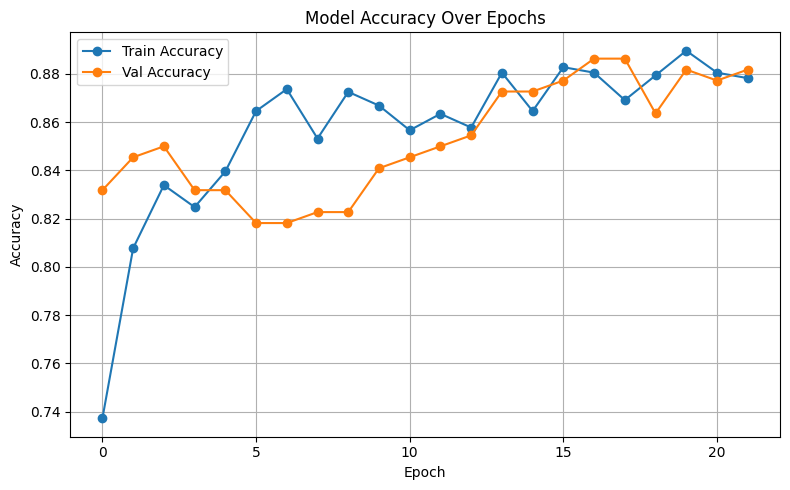

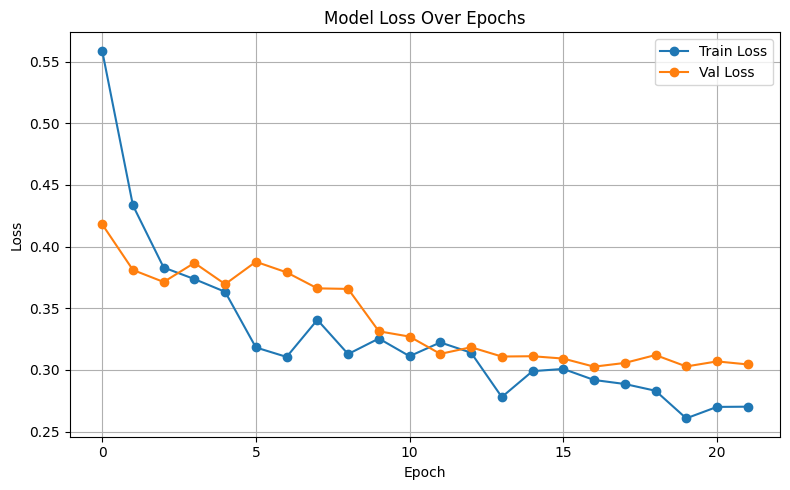

In [ ]:
# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


##ROC Curve

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step


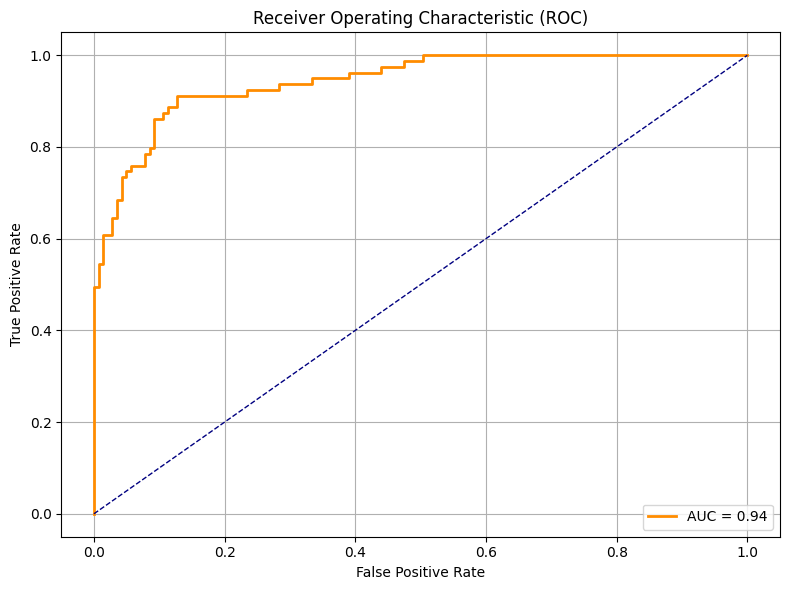

In [ ]:
from sklearn.metrics import roc_auc_score

y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


##Confusion Matrix

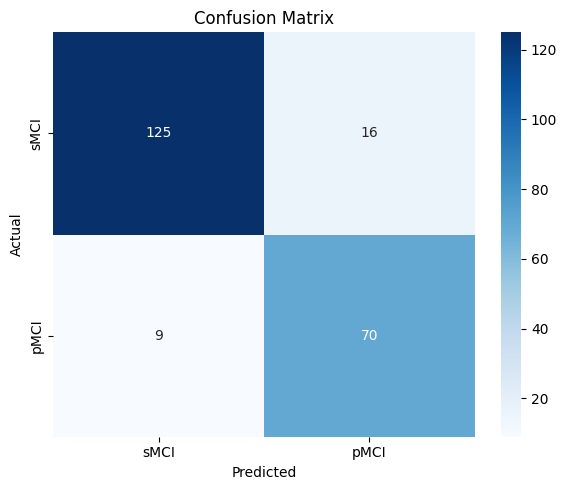

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_label = (y_pred_prob >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_label)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['sMCI', 'pMCI'], yticklabels=['sMCI', 'pMCI'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

# Threshold predictions at 0.5
y_pred_prob = model.predict(X_test).ravel()
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_label)

# Print counts
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (sMCI correctly predicted): {tn}")
print(f"False Positives (sMCI predicted as pMCI): {fp}")
print(f"False Negatives (pMCI predicted as sMCI): {fn}")
print(f"True Positives (pMCI correctly predicted): {tp}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True Negatives (sMCI correctly predicted): 125
False Positives (sMCI predicted as pMCI): 16
False Negatives (pMCI predicted as sMCI): 9
True Positives (pMCI correctly predicted): 70


##Precision-Recall Curve

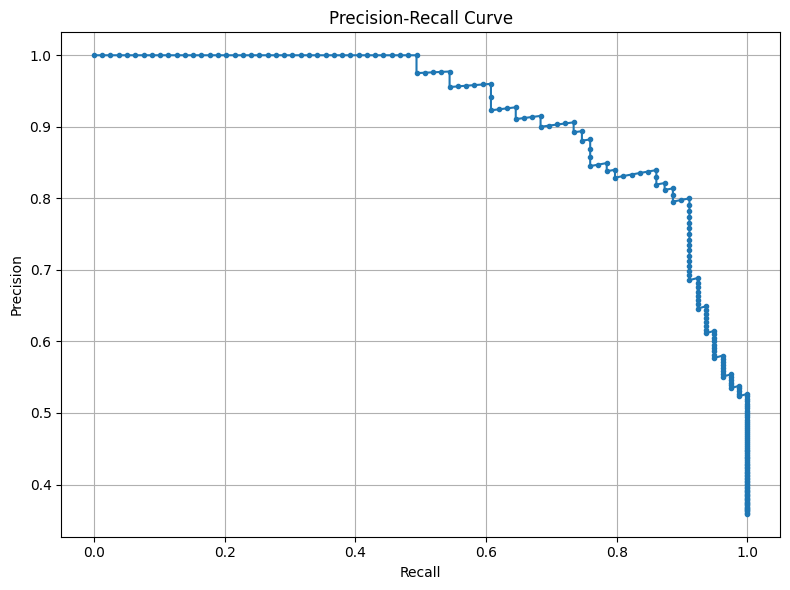

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.tight_layout()
plt.show()

##Sensitivity and Specificity

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


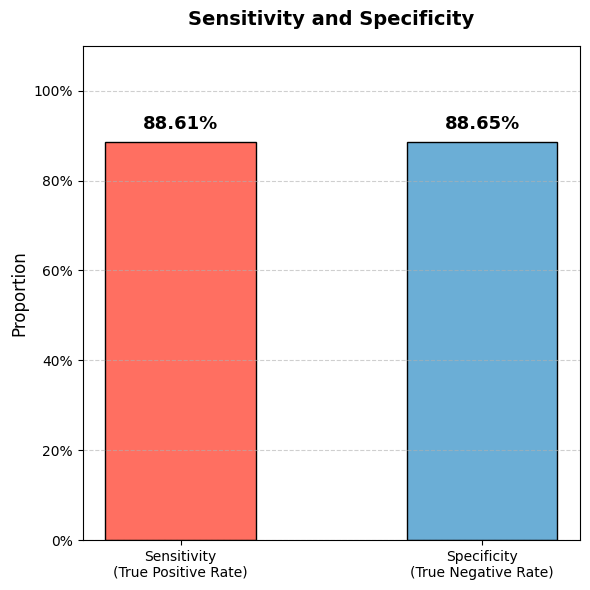

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict and compute
y_pred_labels = (model.predict(X_test).ravel() >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_labels)
tn, fp, fn, tp = cm.ravel()

# Metrics
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

metrics = [sensitivity, specificity]
labels = ['Sensitivity\n(True Positive Rate)', 'Specificity\n(True Negative Rate)']
colors = ['#FF6F61', '#6BAED6']

# Plot
plt.figure(figsize=(6, 6))
bars = plt.bar(labels, metrics, color=colors, edgecolor='black', width=0.5)

# Annotate values
for bar, val in zip(bars, metrics):
    plt.text(bar.get_x() + bar.get_width() / 2, val + 0.02,
             f"{val:.2%}", ha='center', va='bottom', fontsize=13, fontweight='bold')

# Styling
plt.ylim(0, 1.1)
plt.ylabel("Proportion", fontsize=12)
plt.title("Sensitivity and Specificity", fontsize=14, fontweight='bold', pad=15)
plt.yticks(np.linspace(0, 1, 6), [f"{int(x * 100)}%" for x in np.linspace(0, 1, 6)])
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##Summary

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# Predict labels and probabilities
y_pred_probs = model.predict(X_test).ravel()
y_pred_labels = (y_pred_probs >= 0.5).astype(int)

# Confusion matrix breakdown
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_labels)
auc = roc_auc_score(y_test, y_pred_probs)
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)  # same as sensitivity
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred_labels)

# Print in clean format
print("🧠 Model Evaluation Summary:")
print(f"- Accuracy     : {accuracy:.4f}")
print(f"- AUC          : {auc:.4f}")
print(f"- Precision    : {precision:.4f}")
print(f"- Recall (Sensitivity / TPR): {recall:.4f}")
print(f"- Specificity  : {specificity:.4f}")
print(f"- F1 Score     : {f1:.4f}")
print()
print("🧩 Confusion Matrix Breakdown:")
print(f"- True Positives (TP): {tp}")
print(f"- False Positives (FP): {fp}")
print(f"- True Negatives (TN): {tn}")
print(f"- False Negatives (FN): {fn}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
🧠 Model Evaluation Summary:
- Accuracy     : 0.8864
- AUC          : 0.9442
- Precision    : 0.8140
- Recall (Sensitivity / TPR): 0.8861
- Specificity  : 0.8865
- F1 Score     : 0.8485

🧩 Confusion Matrix Breakdown:
- True Positives (TP): 70
- False Positives (FP): 16
- True Negatives (TN): 125
- False Negatives (FN): 9


In [ ]:
# From df_dx (DXSUM file), find MCI-at-baseline
df_bl = df_dx[df_dx['VISCODE2'] == 'bl']
df_bl_mci = df_bl[df_bl['DIAGNOSIS'] == 2.0]
mci_rids = df_bl_mci['RID'].unique()

# Build pMCI / sMCI label dict from longitudinal follow-ups
df_mci_all = df_dx[df_dx['RID'].isin(mci_rids)].copy()
labels = {}
for rid, group in df_mci_all.groupby('RID'):
    diagnoses = group['DIAGNOSIS'].dropna().unique().tolist()
    labels[rid] = 1 if 3.0 in diagnoses else 0


In [ ]:
from collections import Counter

# --- Patient filtering stats ---
print("📌 Patient Selection Summary")
print(f"- Total MCI-at-baseline patients considered: {len(mci_rids)}")

# Label distribution (check if labels is defined)
label_counts = Counter(labels.values())
print(f"- Patients labeled as sMCI (stable): {label_counts[0]}")
print(f"- Patients labeled as pMCI (progressive): {label_counts[1]}")

print(f"- Patients with complete cognitive sequences: {len(patient_sequences)}")

# --- Model input shape and sequence info ---
print("\n📊 Model Input Summary")
print(f"- Input shape to model (X): {X_padded.shape} → [samples, time steps, features]")

# Average unpadded sequence length
sequence_lengths = [len(seq) for seq in patient_sequences.values()]
avg_seq_len = sum(sequence_lengths) / len(sequence_lengths)
print(f"- Average (raw) sequence length per patient: {avg_seq_len:.2f} time points")

# --- Feature names ---
print("\n🧠 Cognitive Features Used:")
feature_names = ['MMSE', 'CDRSB', 'ADAS13', 'RAVLT_immediate',
                 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ']
for i, name in enumerate(feature_names, 1):
    print(f"  {i}. {name}")


📌 Patient Selection Summary
- Total MCI-at-baseline patients considered: 1214
- Patients labeled as sMCI (stable): 816
- Patients labeled as pMCI (progressive): 398
- Patients with complete cognitive sequences: 1099

📊 Model Input Summary
- Input shape to model (X): (1099, 12, 7) → [samples, time steps, features]
- Average (raw) sequence length per patient: 5.23 time points

🧠 Cognitive Features Used:
  1. MMSE
  2. CDRSB
  3. ADAS13
  4. RAVLT_immediate
  5. RAVLT_learning
  6. RAVLT_forgetting
  7. FAQ


In [ ]:
# Build the master DataFrame
master = pd.DataFrame({
    'RID': list(labels.keys()),
    'pMCI': list(labels.values())
})

drive_path = '/content/drive/Shareddrives/ECS289L/'
save_path = drive_path + 'master_subjects.csv'
master.to_csv(save_path, index=False)
print(f'Saved master_subjects.csv → {save_path}')

Saved master_subjects.csv → /content/drive/Shareddrives/ECS289L/master_subjects.csv


In [ ]:

# 1. Read back the file
df = pd.read_csv('/content/drive/Shareddrives/ECS289L/master_subjects.csv')

# 2. Check number of rows and columns
print('Number of entries:', len(df))
print('Columns:', df.columns.tolist())


Number of entries: 1214
Columns: ['RID', 'pMCI']


In [ ]:
# --- Unified cell: weights → embeddings_full.csv for fusion ---

import os, numpy as np, pandas as pd
from tensorflow.keras import Model, Input



# 2) Build an embedder: all layers except the final 2 (BatchNorm+Sigmoid)
input_shape = model.input_shape[1:]
new_input = Input(shape=input_shape)
x = new_input
for layer in model.layers[:-2]:
    x = layer(x)
embed_model = Model(new_input, x)

# 3) Derive valid_rids from your existing patient_sequences dict
#    (built earlier via df_cog.groupby) :contentReference[oaicite:2]{index=2}
valid_rids = list(patient_sequences.keys())

# 4) Sanity-check alignment with X_padded :contentReference[oaicite:3]{index=3}
assert len(valid_rids) == X_padded.shape[0], "❌ valid_rids must match X_padded rows!"

# 5) Load the master list and compute all RIDs
master = pd.read_csv('/content/drive/Shareddrives/ECS289L/master_subjects.csv')
all_rids = set(master['RID'])

# 6) Predict embeddings for available subjects
Z = embed_model.predict(X_padded, batch_size=32)  # shape (N_valid, D)
out_dir = '/content/drive/Shareddrives/ECS289L/embeddings/cog/'
os.makedirs(out_dir, exist_ok=True)

records = []
for rid, vec in zip(valid_rids, Z):
    emb_path = os.path.join(out_dir, f'{rid}.npy')
    np.save(emb_path, vec.astype('float32'))
    records.append({'RID': rid, 'path': emb_path, 'mask': 1})

# 7) Zero-fill & mask=0 for missing RIDs
missing = sorted(all_rids - set(valid_rids))
zero_vec = np.zeros(Z.shape[1], dtype='float32')
for rid in missing:
    emb_path = os.path.join(out_dir, f'{rid}.npy')
    np.save(emb_path, zero_vec)
    records.append({'RID': rid, 'path': emb_path, 'mask': 0})

# 8) Write out the full fusion-ready CSV
full_csv = os.path.join(out_dir, 'embeddings_full.csv')
pd.DataFrame(records).to_csv(full_csv, index=False)
print(f'✔️  Fusion-ready embeddings_full.csv ({len(records)} rows) → {full_csv}')


35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step
✔️  Fusion-ready embeddings_full.csv (1214 rows) → /content/drive/Shareddrives/ECS289L/embeddings/cog/embeddings_full.csv
